# Hybrid DOA project
1. Hybrid array modeling
2. swinging pole modeling
3. DOA algorithm
4. Kalman filter
5. Test banch

# import all nesseccery libraries

In [75]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
from scipy.signal import firwin, lfilter
from scipy.io import loadmat
from scipy.interpolate import CubicSpline
import os
from sklearn.metrics import mean_squared_error
from matplotlib.gridspec import GridSpec
from mpl_toolkits.mplot3d import Axes3D
from collections import deque
from tqdm.notebook import tqdm

# phased array and producing R


Class for Phased array:
- assuming isotropic antennas

In [76]:
class HybridPhasedArray:
    def __init__(self, ant_per_sub, rf_num, dist_between_ant, wave_lambda,number_of_bits=8):
        self.mAntPerSubArray = ant_per_sub
        self.mAntNum = ant_per_sub * rf_num
        self.mRfNun = rf_num
        self.mDistBetweenAnt = dist_between_ant
        self.mLambda = wave_lambda
        self.mWrf = None
        self.mConfigDone = False
        self.mNumberOfBits = number_of_bits

    def Config(self, w_rf):
        self.mWrf = w_rf
        if self.mWrf.shape != (self.mRfNun, self.mAntNum):
            print("XxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXx")
            print("Hybrid phasedArray - Config first!")
            print("XxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXx")
            exit()
        self.mConfigDone = True

    def GetSamples(self, signal, theta):
        if not self.mConfigDone:
          print("XxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXx")
          print("Hybrid phasedArray - Config first!")
          print("XxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXx")
          exit()
        theta = np.deg2rad(theta)
        steeringVector = np.exp(2j * np.pi * np.sin(theta) * np.arange(self.mAntNum)[:, None] * self.mDistBetweenAnt / self.mLambda)
        antenna_outputs = steeringVector @ signal[np.newaxis, :]  # signal is (T,), so result is (N, T)
        received = self.mWrf @ antenna_outputs
        return received

    def GeneratePhase(self):
      numberOfPresentation= 2**(self.mNumberOfBits)
      radResolution= (2*np.pi)/numberOfPresentation
      # All possible discrete phase values
      possibolePresentation = np.array([radResolution * i for i in range(numberOfPresentation)])

      # Randomly choose phases uniformly for each antenna
      subArrayPhaseVec = np.random.choice(possibolePresentation, size=self.mAntPerSubArray, replace=True)

      # Gaussian noise vector
      noise = np.random.normal(loc=0, scale=radResolution/2, size=self.mAntPerSubArray)

      # Add noise to the chosen phases
      noisy_phases = subArrayPhaseVec + noise

      # Complex representation
      complex_phases = np.exp(1j * subArrayPhaseVec)
      complex_noisy_phases = np.exp(1j * noisy_phases)
      return complex_noisy_phases, complex_phases


producing R

In [77]:
class RCalculator:
    def __init__(self, antenna_number, mode, alpha = 0.5):
        self.mAntNum = antenna_number
        self.mR = np.zeros((self.mAntNum, self.mAntNum))
        self.mAlpha = alpha
        self.mMode = mode
        if mode == "alpha filter":
          if self.mAlpha > 1 or self.mAlpha < 0:
              print("XxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxX")
              print("R calculator - Alpha must be less then 1 and more then 0 !!")
              print("XxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxX")
              exit()
        elif mode != "avarage":
              print("XxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxX")
              print("R calculator - mode is not valid -> choose alpha filter or avarage !!")
              print("XxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxX")
              exit()

    def GetSamples(self, inMatrix):
        if self.mMode == "alpha filter":
          for i in range(inMatrix.shape[1]):
              lastSampVec = inMatrix[:,i].reshape(inMatrix.shape[0], 1)
              R = lastSampVec @ lastSampVec.conj().T
              self.mR = (1 - self.mAlpha) * self.mR + self.mAlpha * R
        else:
              self.mR = np.dot(inMatrix, inMatrix.conj().T) / inMatrix.shape[1]
        return self.mR



# DOA algorithms

## Comlexity Helper

In [78]:
def CalcNumberOfMulti(A_shape,B_sahpe):
  return A_shape[0]*B_sahpe[1]*A_shape[1]

def CalcNumberOfAdd(A_shape,B_sahpe):
  return A_shape[0]*B_sahpe[1]*(A_shape[1]-1)

def CalcApproxEigenMulti(A_sahpe):
  return (4/3)*((A_sahpe[0])**3)

## Hybrid MUSIC

In [79]:
class HMusicDoa:
    def __init__(self, ant_num,rf_num, dist_between_ant, wave_lambda, weights_matrix):
        self.mNumberOfAntennas = ant_num
        self.mNumberOfSubArrays=rf_num
        self.mDistBetweenAnt = dist_between_ant
        self.mLambda = wave_lambda
        self.mWeightsMatrix = weights_matrix
        # if self.mWeightsMatrix.shape != (self.mNumberOfAntennas*self.mNumberOfSubArrays, self.mNumberOfAntennas*self.mNumberOfSubArrays):
        #       print("XxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxX")
        #       print("HMusicDoa - Analog weights matrix shape is not valid !!")
        #       print("XxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxX")
        #       exit()
        self.mPower = None
        self.mAngles = None
        ArrayX=[]
        ArrayY=[]
        self.mArrayOfMultiplicationPerScan=[]
        self.mArrayOfMultiplicationPerScan.append(ArrayX)
        self.mArrayOfMultiplicationPerScan.append(ArrayY)

    def UpdateWRF(self, weights_matrix):
      self.mWeightsMatrix = weights_matrix
      if self.mWeightsMatrix.shape != (self.mNumberOfAntennas*self.mNumberOfSubArrays, self.mNumberOfAntennas*self.mNumberOfSubArrays):
              print("XxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxX")
              print("HMusicDoa - Analog weights matrix shape is not valid !!")
              print("XxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxX")
              exit()


    def GetSamples(self, R,  D_obj, dimensionNmber, scanAnglesDeg=np.arange(-90, 91, 1), signal_count=1 ):
        angles = scanAnglesDeg
        power = []
        NumberOfmultiplicationPerScan=0
        for theta_deg in angles:
            D = D_obj.GetD(theta_deg)
            D_inv = np.linalg.inv(D)
            D_inv_conj_H = np.conj(D_inv).T
            R_transformed = D_inv_conj_H @ R @ D_inv
            eigvals, eigvecs = np.linalg.eigh(R_transformed)
            noise_eigvecs = eigvecs[:, :-signal_count]  #vectors with the smallest eigen valuse
            theta = np.deg2rad(theta_deg)
            steering_vec_without_wight=  np.exp(2j * np.pi * self.mDistBetweenAnt * np.sin(theta) * np.arange(self.mNumberOfAntennas * self.mNumberOfSubArrays) / self.mLambda).reshape(-1, 1) #size(ant_num * num_rf,1)
            steering_vec = self.mWeightsMatrix @ steering_vec_without_wight #size(rf_num,1)
            steering_vec_norm = steering_vec / np.linalg.norm(steering_vec)
            power.append(1.0 / np.linalg.norm(np.dot(noise_eigvecs.conj().T, steering_vec_norm))**2)
            #complexity calc
            k = noise_eigvecs.shape[1]
            M= steering_vec_norm.size
            NumberOfmultiplicationPerScan += (CalcApproxEigenMulti(R_transformed.shape) +
                                              self.mNumberOfAntennas * self.mNumberOfSubArrays +
                                              CalcNumberOfMulti(self.mWeightsMatrix.shape,steering_vec_without_wight.shape)+
                                              2*steering_vec.size+
                                              k*M+k-1
                                              )
        self.mArrayOfMultiplicationPerScan[dimensionNmber].append(NumberOfmultiplicationPerScan)
        power = np.abs(power)
        power /= np.max(power)
        power_db = 10 * np.log(power + 1e-6)
        self.mPower = power_db
        self.mAngles = angles
        return angles, power_db

    def PlotPower(self):
        plt.plot(self.mAngles, self.mPower)
        plt.xlabel("Theta [Degrees]")
        plt.ylabel("DOA power calculation")
        plt.grid()
        plt.show()

## MDL - For recieved signls count estimation

In [80]:
class MdlForSigCnt:
    def __init__(self, ant_num, snapshots_for_r_calc,regulationPower):
        self.mAntNum = ant_num
        self.mSnapForRCalc = snapshots_for_r_calc
        self.mregulationPower=regulationPower


    def GetSamples(self, R):
        eigvals, eigvecs = np.linalg.eigh(R)
        eigvals = np.flip(np.sort(eigvals))                          #flip to decent order
        MdlVal = np.zeros(self.mAntNum - 1)
        for sig_vec_num in range(self.mAntNum - 1):
            noise_eigvals = eigvals[sig_vec_num:]
            gm = np.prod(noise_eigvals) ** (1 / len(noise_eigvals))  # geometric mean
            am = np.mean(noise_eigvals)                              # arithmetic mean
            if gm <= 0 or am <= 0:
                MdlVal[sig_vec_num] = np.inf
            else:
                regulation = 0.5 * sig_vec_num * (2 * self.mAntNum - sig_vec_num) * np.log(self.mSnapForRCalc)
                data_term = -self.mSnapForRCalc * (self.mAntNum - sig_vec_num) * np.log(gm / am)
                MdlVal[sig_vec_num] =  data_term + regulation*self.mregulationPower
        EstSigVecsCnt = np.argmin(MdlVal)

        if EstSigVecsCnt == 0:
            print("OoOoOoOoOoOoOoOoOoOoOoOoOoOoOoOoOoOo")
            print("MDL - estimated signal count is 0")
            print("OoOoOoOoOoOoOoOoOoOoOoOoOoOoOoOoOoOo")
            exit()

        return EstSigVecsCnt

# Calibration

In [81]:
class D_creator:
    def __init__(self, ant_num, max_angle, resolution = 0.5, mode = "CubicSpline"):
        self.mD = {}
        self.mAntNum = ant_num
        self.mMaxAngle = max_angle
        self.mResolution = resolution
        self.mInterpulationMode = mode
        self.mInterpulationDone = False

    def GetSample(self, D, angle):
        if D.shape[0] != self.mAntNum | D.shape[1] != self.mAntNum:
            print("XxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXx")
            print("D - D shape is not aligned to the antennas number!")
            print("XxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXx")
            exit()
        self.mD[angle] = D

    def Interpulate(self):
        if self.mInterpulationMode == "ZOH":
            angles = np.arange(-self.mMaxAngle, self.mMaxAngle, self.mResolution)
            tmpDict = {}
            for angle in angles:
                tmpDict[angle] = self.GetClosestD(angle)
            self.mD = tmpDict
        elif self.mInterpulationMode == "CubicSpline":
            original_angles = sorted(self.mD.keys())

            # Prepare interpolators for each diagonal element
            real_splines = []
            imag_splines = []
            for i in range(self.mAntNum):
                real_vals = [np.real(self.mD[angle][i, i]) for angle in original_angles]
                imag_vals = [np.imag(self.mD[angle][i, i]) for angle in original_angles]
                real_splines.append(CubicSpline(original_angles, real_vals))
                imag_splines.append(CubicSpline(original_angles, imag_vals))

            # Interpolate over the full range
            new_angles = np.arange(-self.mMaxAngle, self.mMaxAngle + self.mResolution, self.mResolution)
            tmpDict = {}
            for angle in new_angles:
                D_interp = np.zeros((self.mAntNum, self.mAntNum), dtype=complex)
                for i in range(self.mAntNum):
                    real_val = real_splines[i](angle)
                    imag_val = imag_splines[i](angle)
                    D_interp[i, i] = real_val + 1j * imag_val
                tmpDict[np.round(angle, 6)] = D_interp  # Round key for stability
        else:
            print("XxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXx")
            print("D - Interpulation mode is not valid -> chose ZOH or CubicSpline!")
            print("XxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXx")
            exit()
        self.mD = tmpDict
        self.mInterpulationDone = True

    def GetClosestD(self, angle):
        closest = None
        minDist = np.inf
        for key in self.mD.keys():
            dist = np.abs(angle - key)
            if dist < minDist:
                minDist = dist
                closest = key
        return self.mD[closest]

    def GetD(self, angle):
        if self.mInterpulationDone == False:
            print("XxXxXxXxXxXxXxXxXxXxXx")
            print("D - Interpulate first!")
            print("XxXxXxXxXxXxXxXxXxXxXx")
            exit()
        if np.abs(angle) > self.mMaxAngle:
            print("0000000000000000000000000000000000000000000000000000000000000")
            print("D - Angle is not valid -> max angle is " + str(self.mMaxAngle))
            print("0000000000000000000000000000000000000000000000000000000000000")
            angle = np.clip(angle, -self.mMaxAngle, self.mMaxAngle)
        res = angle % self.mResolution
        key = angle - res
        return(self.mD[key])

    def PlotGainMismatch(self, maxAngle):
      scanAngles = np.arange(-maxAngle, maxAngle + 1)
      element_0 = []
      element_1 = []
      element_2 = []
      element_3 = [] #Jump here
      for theta in scanAngles:
        theta = int(theta)
        matrix=self.mD[theta]
        element_0.append(np.abs(matrix[0,0]))
        element_1.append(np.abs(matrix[1,1]))
        element_2.append(np.abs(matrix[2,2]))
        element_3.append(np.abs(matrix[3,3]))
      # Plotting
      plt.figure(figsize=(10, 6))
      plt.plot(scanAngles, element_0, label='Element 0')
      plt.plot(scanAngles, element_1, label='Element 1')
      plt.plot(scanAngles, element_2, label='Element 2')
      plt.plot(scanAngles, element_3, label='Element 3')
      plt.xlabel("Scan Angle (degrees)")
      plt.ylabel("Gain Mismatch (abs of diag element)")
      plt.title("Gain Mismatch vs Scan Angle")
      plt.grid(True)
      plt.legend()
      plt.tight_layout()
      plt.show()

    def PlotPhaseMismatch(self, maxAngle):
      scanAngles = np.arange(-maxAngle, maxAngle + 1)
      element_0 = []
      element_1 = []
      element_2 = []
      element_3 = []
      for theta in scanAngles:
        theta = int(theta)
        matrix=self.mD[theta]
        element_0.append(np.angle(matrix[0,0]))
        element_1.append(np.angle(matrix[1,1]))
        element_2.append(np.angle(matrix[2,2]))
        element_3.append(np.angle(matrix[3,3]))
      # Plotting
      plt.figure(figsize=(10, 6))
      plt.plot(scanAngles, element_0, label='Element 0')
      plt.plot(scanAngles, element_1, label='Element 1')
      plt.plot(scanAngles, element_2, label='Element 2')
      plt.plot(scanAngles, element_3, label='Element 3')
      plt.xlabel("Scan Angle (degrees)")
      plt.ylabel("Phase Mismatch (angles of diag element)")
      plt.title("Phase Mismatch vs Scan Angle")
      plt.grid(True)
      plt.legend()
      plt.tight_layout()
      plt.show()

In [82]:
def D_Builder(DicOfRawData, maxAngel=60, resolution=10 ,distance=0.5*(3e8 / 28e9),wave_length=3e8 / 28e9 ,num_of_antennas=4, reference_ant=0):
    """
    bulding D depends on the given data from each degree.

    Parameters:
    arrayOfRawData (ndarray): m x n x 4 raw signal matrix (complex) where
        -m is for the rawData from specific theta and n is the number of sampling
        -n is the number of sampling
        -4 is the number of antennas
    reference_ant (int): Index of the reference antenna (0-based)

    Returns:
    dictionary with D matrix arrays 4 x 4: m degrees and each one has 4 x 4 GP mismtach
    """
    D_MatrixDic= {}
    theta = -maxAngel

    # #start with theta 0
    # rawData= DicOfRawData[0]
    # # get the mismatch
    # gain_mismatch, _= cgain(rawData,reference_ant) #shape of (4,)
    # gain_mismatch_zero= gain_mismatch[0]
    # phase_mismatch, _= cphase(rawData=rawData,theta=0,wave_length=wave_length,distance=distance,num_of_antennas=num_of_antennas,reference_ant=reference_ant) #shape of (4,)
    # #make them diagonal
    # gain_diag= np.diag(gain_mismatch / (gain_mismatch_zero + 1e-12)) #shape of 4x4
    # phase_diag= np.diag(phase_mismatch) #shape of 4x4
    # #calculate D
    # D= gain_diag @ phase_diag #shape of 4x4
    # #insert it to dictionary
    # D_MatrixDic[0]= D



    for i in DicOfRawData:
      # if (theta == 0):
      #   continue
      rawData= DicOfRawData[theta]
      # ~~~~~~~ get the mismatch ~~~~~~~
      gain_mismatch, _= cgain(rawData,reference_ant) #shape of (4,)
      phase_mismatch, _= cphase(rawData=rawData,theta=theta,wave_length=wave_length,distance=distance,num_of_antennas=num_of_antennas,reference_ant=reference_ant) #shape of (4,)
      #  ~~~~~~~  make them diagonal ~~~~~~~
      # gain_diag= np.diag(gain_mismatch / (gain_mismatch_zero + 1e-12)) #shape of 4x4
      gain_diag= np.diag(gain_mismatch) #shape of 4x4
      phase_diag= np.diag(phase_mismatch) #shape of 4x4
      #  ~~~~~~~  calculate D ~~~~~~~
      D= gain_diag @ phase_diag #shape of 4x4
      #  ~~~~~~~ insert it to dictionary ~~~~~~~
      D_MatrixDic[theta]= D
      theta += resolution

    return D_MatrixDic

In [83]:
def cphase(rawData,theta,wave_length,distance,num_of_antennas,reference_ant):
    """
    Calibrates phases using FFT phase estimation.

    Parameters:
    rawData (ndarray): n x 4 raw signal matrix (complex)
    reference_ant (int): Index of the reference antenna (0-based)

    Returns:
    fixed_rawData (ndarray): n x 4 phase-aligned signal matrix
    weights (ndarray): 4 x 1 vector of complex weights for phase alignment
    """
    if not isinstance(rawData, np.ndarray) or not isinstance(reference_ant, int):
        print("XxXxXxXxXxXxXxXxXxXxXx")
        print("rawData must be a matrix and reference_ant an integer")
        print("XxXxXxXxXxXxXxXxXxXxXx")
        exit()

    max_val = np.zeros(4, dtype=complex) # (0,0,0,0)

    # FFT and find the max in frequency domain
    for i in range(4):
        rawFt = np.fft.fftshift(np.fft.fft(rawData[:, i]))
        max_val[i] = rawFt[np.argmax(np.abs(rawFt))]

    angs = np.angle(max_val) #shape (4,) - 1 D
    ant_indices = np.arange(num_of_antennas) # (0,1,2,3) shape (4,) - 1 D
    steering_vector= (2*np.pi* ant_indices * (distance/wave_length))*np.sin(np.deg2rad(theta))
    cal_angs= angs- steering_vector #shape (4,) - 1 D
    cal_angs= cal_angs- angs[reference_ant]
    weights = np.exp(-1j * cal_angs)
    fixed_rawData = rawData * weights  # broadcasting applies each weight column-wise
    return weights, fixed_rawData

def cgain(rawData, reference_ant):
    """
    Calibrates Gain using norm.

    Parameters:
    rawData (ndarray): n x 4 raw signal matrix (complex)
    reference_ant (int): Index of the reference antenna (0-based)

    Returns:
    fixed_rawData (ndarray): n x 4 phase-aligned signal matrix
    gain_mismatch (ndarray): 4 x 1 vector of gain weights
    """
    if not isinstance(rawData, np.ndarray) or not isinstance(reference_ant, int):
        print("XxXxXxXxXxXxXxXxXxXxXx")
        print("rawData must be a matrix and reference_ant an integer")
        print("XxXxXxXxXxXxXxXxXxXxXx")
        exit()

    N = rawData.shape[0]  # number of time samples
    norm_val= np.zeros(4)
    for i in range(4):
        antennaData=rawData[:,i]
        norm_val[i] = np.linalg.norm(antennaData)  # Frobenius norm (L2 over elements i)
    #FIX- If theta is 0 return it and devide all with the first antenna gain
    gain_mismatch = (norm_val / np.sqrt(N))
    gain_mismatch= gain_mismatch / gain_mismatch[reference_ant]  # FIX- maybe?
    fixed_rawData= rawData * gain_mismatch
    #gain_mismatch= np.zeros(4, dtype=complex)
    return gain_mismatch, fixed_rawData

In [84]:
def GetCalibrationMatrix(ant_num, DicOfRawData ,maxAngel, resolution_cal=10,resolution_theta=1, reference_ant=0):
    #build D with the given raw data array
    D_matrix_of_m_thetas= D_Builder(DicOfRawData=DicOfRawData,maxAngel=maxAngel, resolution=resolution_cal, reference_ant=reference_ant)
    #create the object
    D = D_creator(ant_num=ant_num, max_angle=maxAngel, resolution = resolution_theta)
    #enter all the sampling
    for angle, matrix in D_matrix_of_m_thetas.items():
        D.GetSample(matrix,angle)
    #preform the intarpulatin
    D.Interpulate()
    return D

# Support classes

### Peaks finder

In [85]:
class PeaksFinder:

    def __init__(self, peaks_num):
        self.mPeaksNum = peaks_num
        if self.mPeaksNum < 1:
            print("XxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXx")
            print("Peaks finder - Enter at least one peak to find !!!")
            print("XxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXx")
            exit()

    def GetSamples(self, power_values, scanAnglesDeg):
        peaksIdx = find_peaks(np.squeeze(power_values))[0]
        if len(peaksIdx) == 0:
            print("000000000000000000000000000000000000000000")
            print("Peaks finder - No maximum points found !!!")
            print("000000000000000000000000000000000000000000")
        if self.mPeaksNum > len(peaksIdx):
            print("000000000000000000000000000000000000000000000000000")
            print("Peaks finder - Didnt found anoth maximum points !!!")
            print("000000000000000000000000000000000000000000000000000")
        peaksPowers = power_values[peaksIdx]
        sortedIndices = np.argsort(peaksPowers)[::-1]
        topPeaksIdx = peaksIdx[sortedIndices[:self.mPeaksNum]]
        topAngles = scanAnglesDeg[topPeaksIdx.tolist()]

        # ~~~~ If error - return -200 (for kalmans override) ~~~~ #
        if len(topAngles) < self.mPeaksNum:
            topAngles = list(topAngles) + [-200] * (self.mPeaksNum - len(topAngles))
        if self.mPeaksNum == 1:
            return topAngles[0]
        else:
            return topAngles

# Kalman Filter



### Linear Kalman Filter (LKF)

In [86]:
class LKF:
    def __init__(self, init_pos, init_vel, init_var, measurments_var, proccess_variance, omega = 0):
        self.mX = np.array([[init_pos],
                            [init_vel]])
        self.mP = np.array([[init_var, 0],
                            [0, init_var]])
        self.mR = np.array([[measurments_var]])
        self.mQ = proccess_variance * np.eye(2)
        self.mOmega = omega

    def GetSampels(self, input, dt):
        if isinstance(input, np.ndarray):
          outVec = []
          outVarVec = []
          for sample in input:
              if -91 < sample < 91:
                  pos, var = self.ApplyFilter(sample, dt)
              else:
                  pos, var = self.Override(dt)
              outVec.append(pos)
              outVarVec.append(var)
          return np.array(outVec), np.array(outVarVec)
        else:
          if -91 < input < 91:
              pos, var = self.ApplyFilter(input, dt)
          else:
              pos, var = self.Override(dt)
          return pos, var

    def Override(self, dt):
        F = np.array([[1, dt],
                      [-self.mOmega**2 * dt, 1]])
        H = np.array([[1, 0]])
        I = np.eye(2)

        # --- Prediction only ---
        self.mX = F @ self.mX
        self.mP = F @ self.mP @ F.T + self.mQ

        return self.mX[0, 0], self.mP[0, 0]

    def ApplyFilter(self, measuredPos, dt):
        F = np.array([[1, dt],
                      [-self.mOmega**2 * dt, 1]])
        H = np.array([[1, 0]])
        I = np.eye(2)

        # --- Prediction ---
        self.mX = F @ self.mX
        self.mP = F @ self.mP @ F.T + self.mQ

        # --- Update ---
        z = np.array([[measuredPos]])
        y = z - H @ self.mX
        S = H @ self.mP @ H.T + self.mR
        K = self.mP @ H.T @ np.linalg.inv(S)

        # --- Estimation ---
        self.mX = self.mX + K @ y
        self.mP = (I - K @ H) @ self.mP

        return self.mX[0, 0], self.mP[0, 0]

### Extanded Kalman Filter (EKF)
For oscilator tracking

In [87]:
class EKF:
    def __init__(self, init_angle, init_angularVelocity,init_Omega, init_var, measurments_var, proccess_variance,dt):
        self.mX = np.array([[init_angle],
                            [init_angularVelocity],
                            [init_Omega]])
        self.mX_predict=None
        self.mP = init_var * np.eye(3)
        self.mP_predict = None
        self.mR =  np.array([[measurments_var]])
        self.mQ = proccess_variance * np.eye(3)
        self.mH =np.array([[1,0,0]])
        self.mI= np.eye(3)
        self.mdt=dt
        self.mArrayOfmultiplications=[]
        self.OnlyPrediction()

    def OnlyPrediction(self):
      new_theat= self.mX[0,0]+ self.mdt*self.mX[1,0]
      new_theta_dot= self.mX[1,0] - self.mdt*self.mX[0,0]*self.mX[2,0] ** 2
      new_omega = self.mX[2,0]

      F_Jacobian = np.array([[1, self.mdt,0],
                            [-(self.mX[2,0]**2) * self.mdt, 1, -2* self.mX[2,0] * self.mX[0,0] * self.mdt],
                            [0, 0, 1]])
      # --- Prediction ---
      self.mX_predict = np.array([[new_theat],
                  [new_theta_dot],
                  [new_omega]])
      self.mP_predict = F_Jacobian @ self.mP @ F_Jacobian.T + self.mQ


    def GetSampels(self, input):
        if isinstance(input, np.ndarray):
          outStateVec = []
          outVarVec = []
          for sample in input:
              if -91 < sample < 91:
                  stateVec, varianceMatrix = self.ApplyFilter(sample) #get the state vector and the variance matrix
              else:
                  stateVec, varianceMatrix = self.Override()
              outStateVec.append(stateVec.flatten())
              outVarVec.append(np.diag(varianceMatrix))
          return np.array(outStateVec), np.array(outVarVec)
        else:
          if -91 < input < 91:
              stateVec, varianceMatrix = self.ApplyFilter(input)
          else:
              stateVec, varianceMatrix = self.Override()
          return stateVec.flatten(), np.diag(varianceMatrix)

    def Override(self):
        # --- Update ---
        self.mX = self.mX_predict
        self.mP=self.mP_predict

        # --- Prediction only ---
        new_theat= self.mX[0,0]+ self.mdt*self.mX[1,0]
        new_theta_dot= self.mX[1,0] - self.mdt*self.mX[0,0]*self.mX[2,0] ** 2
        new_omega = self.mX[2,0]

        F_Jacobian = np.array([[1, self.mdt,0],
                               [-(self.mX[2,0]**2) * self.mdt, 1, -2* self.mX[2,0] * self.mX[0,0] * self.mdt],
                               [0, 0, 1]])


        self.mX_predict = np.array([[new_theat],
                    [new_theta_dot],
                    [new_omega]])
        self.mP_predict = F_Jacobian @ self.mP @ F_Jacobian.T + self.mQ


        return self.mX, self.mP


    def ApplyFilter(self, measuredPos):

        # ==== Update ====

        #Kalman Gain Update
        K= self.mP_predict @ self.mH.T @ np.linalg.inv( self.mH @ self.mP_predict @ self.mH.T+ self.mR)
        #State Update
        z = np.array([[measuredPos]])
        self.mX= self.mX_predict + K @ (z-self.mH@ self.mX_predict)
        #Variance Update
        helperFor_mP_calc= (self.mI - K @ self.mH)
        self.mP = helperFor_mP_calc @ self.mP_predict @ helperFor_mP_calc.T + K @ self.mR @ K.T

        # ==== Prediction ====
        #calculate f(x_(n,n)) because it is not linear and we can not write it as a matrix
        new_theat= self.mX[0,0]+ self.mdt*self.mX[1,0]
        new_theta_dot= self.mX[1,0] - self.mdt*self.mX[0,0]*self.mX[2,0] ** 2
        new_omega = self.mX[2,0]
        #Jacobian
        F_Jacobian = np.array([[1, self.mdt,0],
                               [-(self.mX[2,0]**2) * self.mdt, 1, -2* self.mX[2,0] * self.mX[0,0] * self.mdt],
                               [0, 0, 1]])
        #predict
        self.mX_predict = np.array([[new_theat],
                    [new_theta_dot],
                    [new_omega]])
        self.mP_predict = F_Jacobian @ self.mP @ F_Jacobian.T + self.mQ

        # ==== Complexity ====
        multNum =(9+ #the first build
                  54+ #Prediction
                  24+ #Kalman Update
                  6+ #update mX
                  36 #update mP
                  )
        self.mArrayOfmultiplications.append(multNum)

        return self.mX, self.mP



# Targets classes

## UAV

In [88]:
class UAV:
  def __init__(self, starting_point=0,left_side=-10,right_side=10):
    self.mStartingPoint=starting_point
    self.mLeftSide=left_side
    self.mRightSide= right_side

  def OscillatorMovment(self,omega=1,range=20,durationTime=60,numberOfPointsToMeasure=121): #Samplee rate + range to amplitude and cemnter
    time=np.linspace(0,durationTime,numberOfPointsToMeasure)
    UAV_position_results=[]
    UAV_Postition=0
    for t in time:
      UAV_Postition = self.mStartingPoint +range*np.sin(omega*t)
      UAV_position_results.append(float(UAV_Postition))
    return UAV_position_results
  def StraightMovment(self,velocity=1,durationTime=20,numberOfPointsToMeasure=21):
      time=np.linspace(0,durationTime,numberOfPointsToMeasure)
      UAV_position_results=[]
      UAV_Postition=0
      for i in range(1, len(time)):
          delta_t = time[i] - time[i - 1]
          UAV_Postition += velocity*delta_t
          UAV_position_results.append(float(UAV_Postition))
      return UAV_position_results
  def ColumnMoveOscilatory(self,hight,K,windForce,durationTime=60,numberOfPointsToMeasure=121):
    pass



## Swinging pole

In [89]:
class SwingingPole:

    """
    Pole sway simulator using the spectral-representation method
    Based on Hur et al. 'Millimeter Wave Beamforming for Wireless Backhaul and Access in Small Cell Networks'
    """

    def __init__(self,
                 T=100, Fs=2000, D=100,
                 u_avg=13,
                 m=5,
                 hight=10,
                 dp=0.5,
                 seed=None):

        self.T = T          # Simulation time [s]
        self.Fs = Fs        # Sampling rate [Hz]
        self.D = D          # Antennas distance [m]
        self.u_avg = u_avg  # Wind speed [m/s]
        self.rho_a = 1.22   # Air dansity [Kg/m^3]
        self.C_D = 0.5      # Drug coefficient [None]
        self.A_e = 0.09     # Affective pole area [m^2]
        self.m = m          # Pole and antenna mass [Kg]
        self.f_n = 1        # Natural pole oscilation frequency [Hz]
        self.zeta = 0.002   # Pole movement damping ratio [None]
        self.z0 = 2         # Terrain roughness [m]
        self.hight = hight  # Pole hight [m]
        self.dp = dp        # Pole diameter [m]
        self.S = 0.2        # Vortex parameter
        self.seed = seed

        self.t = None       # Time vector [s]
        self.Ld = None      # Displacement along the wind [m]
        self.Lc = None      # Displacement vertical to the wind [m]
        self.theta_d = None   # Affective misalignment angle along the win [deg]
        self.theta_c = None   # Affective misalignment angle vertical to the win [deg]

    def run(self):

        # Time and frequency grids
        N = int(self.T * self.Fs)
        dt = 1.0 / self.Fs
        t = np.arange(N) * dt
        df = self.Fs / N
        f = np.arange(N) * df

        """ Assuming wind only in the x and y directions since closness to the ground"""
        # Wind velocity field PSD - u = u_avg + Ud [d direction] + Uc [c direction]
        kappa = 0.5 * self.rho_a * self.C_D * self.A_e
        u_star = self.u_avg / (2.5 * np.log(self.hight / self.z0))
        f_vs = self.S * self.u_avg / self.dp
        Sud = (500 * u_star**2) / (np.pi * self.u_avg) * (1.0 / (1.0 + 500 * f / (2*np.pi*self.u_avg)))**(5.0/3.0)
        Suc = ( 75 * u_star**2) / (2*np.pi * self.u_avg) * (1.0 / (1.0 +  95 * f / (2*np.pi*self.u_avg)))**(5.0/3.0)

        # Applied forcs PSD
        SFd = (2 * kappa * self.u_avg)**2 * Sud
        SFc = (    kappa * self.u_avg)**2 * Suc

        """ Wind flowing torword the pole creates a vacume behind it which creating ocsilating drug force - vortex shreding"""
        # Vortex shedding PSD
        SF_vs = kappa**2 * 1.125 * np.sqrt(np.pi * np.divide(f, f_vs, out=np.zeros_like(f), where=f_vs!=0)) \
                * np.exp(-((1.0 - np.divide(f, f_vs, out=np.zeros_like(f), where=f_vs!=0))**2) / 0.18)

        # Mechanical pole transfer function
        ratio = np.divide(f, self.f_n, out=np.zeros_like(f), where=self.f_n!=0)
        Hm = 1.0 / (4.0 * self.m * np.pi**2 * self.f_n**2 *
                    np.sqrt((1 - ratio**2)**2 + (2*self.zeta*ratio)**2))
        SLd = np.abs(Hm)**2 * SFd
        SLc = np.abs(Hm)**2 * (SFc + SF_vs)

        # Finale movement PSD adding random phases
        Npos = N//2 + 1 if N % 2 == 0 else (N + 1)//2
        rng = np.random.default_rng(self.seed)
        phi1 = rng.random(Npos) * 2*np.pi
        phi2 = rng.random(Npos) * 2*np.pi
        Delta_f = self.Fs / N
        Sd_pos = (N/2.0) * np.sqrt(2.0 * SLd[:Npos] * Delta_f) * np.exp(1j * phi1)
        Sc_pos = (N/2.0) * np.sqrt(2.0 * SLc[:Npos] * Delta_f) * np.exp(1j * phi2)
        Sd_full = np.zeros(N, dtype=complex)
        Sc_full = np.zeros(N, dtype=complex)
        Sd_full[:Npos] = Sd_pos
        Sc_full[:Npos] = Sc_pos
        if N % 2 == 0:
            Sd_full[Npos:] = np.conj(Sd_pos[1:-1][::-1])
            Sc_full[Npos:] = np.conj(Sc_pos[1:-1][::-1])
        else:
            Sd_full[Npos:] = np.conj(Sd_pos[1:][::-1])
            Sc_full[Npos:] = np.conj(Sc_pos[1:][::-1])

        #Exctracing freq
        Ld_freq= f[np.argmax(SLd)]
        Lc_freq= f[np.argmax(SLc)]
        # Creating position vector using IFFT
        Ld = np.real(np.fft.ifft(Sd_full))
        Lc = np.real(np.fft.ifft(Sc_full))
        theta_d = np.degrees(np.arctan2(Ld, self.D))
        theta_c = np.degrees(np.arctan2(Lc, self.hight))
        #calculate the velocity
        velocity_d = np.zeros_like(theta_d)
        velocity_d[0] = 0
        velocity_d[1:] = (theta_d[1:] - theta_d[:-1]) / dt
        velocity_c = np.zeros_like(theta_d)
        velocity_c[0] = 0
        velocity_c[1:] = (theta_d[1:] - theta_d[:-1]) / dt

        self.t, self.Ld, self.Lc, self.theta_d, self.theta_c = t, Ld, Lc, theta_d, theta_c
        return theta_d, theta_c, Ld_freq, Lc_freq, velocity_d, velocity_c

    def plot_results(self):           # Continue - adjust to 2D
        """Plot time series and 3D sway trajectory."""
        if self.t is None or self.Ld is None:
            raise RuntimeError("Run the simulation first using .run()")

        fig = plt.figure(figsize=(12, 9))
        gs = GridSpec(3, 3, figure=fig)

        # 3D scatter
        ax3d = fig.add_subplot(gs[:, 1:], projection='3d')
        sc = ax3d.scatter(self.Lc*100.0, self.Ld*100.0, self.t, s=2, c=self.t)
        ax3d.set_title('Pole sway – $L_c(t)$ vs. $L_d(t)$')
        ax3d.set_xlabel('$L_c$ [cm]')
        ax3d.set_ylabel('$L_d$ [cm]')
        ax3d.set_zlabel('Time [s]')
        cb = fig.colorbar(sc, ax=ax3d, fraction=0.03, pad=0.08)
        cb.set_label('Time [s]')

        # Cross-wind
        ax1 = fig.add_subplot(gs[0, 0])
        ax1.plot(self.t, self.Lc*100.0)
        ax1.set_title('Pole sway – cross-wind $L_c(t)$')
        ax1.set_xlabel('Time [s]')
        ax1.set_ylabel('$L_c$ [cm]')

        # Along-wind
        ax2 = fig.add_subplot(gs[1, 0])
        ax2.plot(self.t, self.Ld*100.0)
        ax2.set_title('Pole sway – along-wind $L_d(t)$')
        ax2.set_xlabel('Time [s]')
        ax2.set_ylabel('$L_d$ [cm]')

        # Tilt angle
        ax3 = fig.add_subplot(gs[2, 0])
        ax3.plot(self.t, self.theta_d)
        ax3.set_title('Tilt angle $\\theta_L(t)$')
        ax3.set_xlabel('Time [s]')
        ax3.set_ylabel('$\\theta_L$ [deg]')

        fig.suptitle('Pole sway time series', fontsize=14)
        plt.tight_layout()
        plt.show()

# Test Banch

## Test banch functions

In [90]:
def PlotResults(before_kalman, after_kalman, ci, real_position=None, Ts=1, title=None, y_lim=90):
    if len(before_kalman) != len(after_kalman):
        print("XxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXx")
        print("Plot function - Inputs are not the same length !!!") # Fixed typo: langth -> length
        print("XxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXx")
        exit()
    time = np.arange(len(before_kalman)) * Ts
    plt.figure(figsize=(10, 5))
    # FIX: Changed 'y = ...', 'x = ...' to positional arguments
    plt.plot(time, before_kalman, linestyle='--', color='red', label='Before Kalman', linewidth=2)
    plt.plot(time, after_kalman, linestyle='-', color='orange', label='After Kalman', linewidth=2)
    plt.fill_between(time, after_kalman - ci, after_kalman + ci, color='orange', alpha=0.3, label='95% CI')

    if real_position is not None:
        if len(before_kalman) != len(real_position):
            print("XxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXx")
            print("Plot function - Inputs are not the same length !!!") # Fixed typo: langth -> length
            print("XxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXx")
            exit()
        # FIX: Changed 'y = ...', 'x = ...' to positional arguments
        plt.plot(time, real_position, linestyle='--', color='green', label='Real position', linewidth=2)

    plt.xlabel('Time (s)')
    plt.ylabel('Angle (Degrees)')
    plt.ylim([-y_lim, y_lim])
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

def PlotCompareBetween_LKF_and_EKF(before_kalman, after_kalman_LKF, after_kalman_EKF, ci, real_position=None, Ts=1, title=None, y_lim=90):
    if ((len(before_kalman) != len(after_kalman_LKF)) | (len(before_kalman) != len(after_kalman_EKF))):
        print("XxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXx")
        print("Plot function - Inputs are not the same length !!!") # Fixed typo: langth -> length
        print("XxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXx")
        exit()
    time = np.arange(len(before_kalman)) * Ts
    plt.figure(figsize=(10, 5))
    # FIX: Changed 'y = ...', 'x = ...' to positional arguments
    plt.plot(time, before_kalman, linestyle='--', color='red', label='Before Kalman', linewidth=2)
    plt.plot(time, after_kalman_LKF, linestyle='-', color='orange', label='after Kalman LKF', linewidth=2)
    plt.plot(time, after_kalman_EKF, linestyle='-', color='blue', label='after Kalman EKF', linewidth=2)

    if real_position is not None:
        if len(before_kalman) != len(real_position):
            print("XxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXx")
            print("Plot function - Inputs are not the same length !!!") # Fixed typo: langth -> length
            print("XxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXx")
            exit()
        # FIX: Changed 'y = ...', 'x = ...' to positional arguments
        plt.plot(time, real_position, linestyle='--', color='green', label='Real position', linewidth=2)

    plt.xlabel('Time (s)')
    plt.ylabel('Angle (Degrees)')
    plt.ylim([-y_lim, y_lim])
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

def GenInputFrames(Data, position_vec ,num_of_samples):
    inputFrames = []
    for pos in position_vec:
        rawData = Data[pos]
        frame = np.array(rawData[:num_of_samples])
        inputFrames.append(frame)
    return inputFrames

def plot_mse_vs_ratio(ratio_array, mse_arrays, filter_name):
    """
    Plots MSE vs Ratio for a given filter with three methods.
    Parameters:
    - ratio_array: array of ratio values (x-axis)
    - mse_arrays: list of 3 arrays [DS, MVDR, MUSIC] (y-axis)
    - filter_name: string, name of the filter (e.g. 'LKF', 'EKF')
    """
    methods = ['DS', 'MVDR', 'MUSIC']
    fig, axs = plt.subplots(1, 3, figsize=(20, 8), sharey=True)
    fig.suptitle(f'MSE vs Ratio for {filter_name}', fontsize=16)
    for ax, mse, method in zip(axs, mse_arrays, methods):
        ax.plot(ratio_array, mse, label=f'{filter_name} - {method}')
        ax.set_xlabel('Ratio')
        ax.set_ylabel('MSE')
        ax.set_title(f'{filter_name} - {method}')
        ax.grid(True)
        ax.legend()
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

def PlotSimulation(state_variance_plot,
         number_of_dimensions,
         Titel,
         pole_movement_vec,
         est_angles_before_kalman_vec,
         est_angles_after_kalman_vec,
         est_angles_velocities_kalman_vec,
         est_omega_after_kalman_vec,
         ciPosition,
         ciVelocity,
         ciOmega,
         mse_before_vec,
         mse_after_vec):
    #  --- Count the number of plots ---
    to_plot_indices = [i for i, (plot_val, plot_var) in enumerate(state_variance_plot)
                if plot_val]
    n_plots = len(to_plot_indices)
    #  --- Create the sub plots ---
    fig, axes = plt.subplots(n_plots, number_of_dimensions, figsize=(16, 6 * n_plots))
    axes = axes.flatten()
    counter=0
    #  --- plot via the state_variance_plot matrix ---
    for i, (plot_value, plot_variance) in enumerate(state_variance_plot):
      if i == 0:  # position
          if plot_value:
            for j in range(number_of_dimensions):
              ax = axes[counter]
              counter += 1
              ax.plot(pole_movement_vec[j], label="True angle", color='blue')
              ax.plot(est_angles_before_kalman_vec[j],
                      label="Estimated angle before kalman (H-MUSIC)",
                      color ='green')
              ax.plot(est_angles_after_kalman_vec[j],
                      label="Estimated angle after kalman (H-MUSIC)",
                      color='orange')
              ax.set_xlabel("Sample index")
              ax.set_ylabel("Angle (degrees)")
              ax.set_title(Titel[j])  # individual title above each subplot
              ax.grid(True)
              ax.legend(loc='upper right', bbox_to_anchor=(1, 1), frameon=True)

              if plot_variance:
                  ax.fill_between(
                      np.arange(len(est_angles_after_kalman_vec[j])),
                      est_angles_after_kalman_vec[j] - ciPosition[j],
                      est_angles_after_kalman_vec[j] + ciPosition[j],
                      color='orange', alpha=0.3, label='95% CI for Angle'
              )
      elif i == 1:  # angle velocity
          if plot_value:
              for j in range(number_of_dimensions):
                ax = axes[counter]
                counter += 1
                ax.plot(pole_movement_vec[j+4], label="True angle Velocity")
                ax.plot(est_angles_velocities_kalman_vec[j],
                        label="Estimated angle Velocity after kalman (H-MUSIC)",
                        color='orange')
                ax.set_xlabel("Sample index")
                ax.set_ylabel("Angle Velocity (degree/sec)")
                ax.set_title(Titel[j+2])  # individual title above each subplot
                ax.grid(True)
                ax.legend(loc='upper right', bbox_to_anchor=(1, 1), frameon=True)
                if plot_variance:
                    ax.fill_between(
                        np.arange(len(est_angles_velocities_kalman_vec[j])),
                        est_angles_velocities_kalman_vec[j] - ciVelocity[j],
                        est_angles_velocities_kalman_vec[j] + ciVelocity[j],
                        color='orange', alpha=0.3, label='95% CI for Angle velocity'
                )
      elif i == 2:  # omega
          if plot_value:
              for j in range(number_of_dimensions):
                omega = np.ones_like(est_omega_after_kalman_vec[j]) * pole_movement_vec[j+2] * 2 * np.pi
                ax = axes[counter]
                counter += 1
                ax.plot(omega, label="True omega", color='blue')
                ax.plot(est_omega_after_kalman_vec[j],
                        label="Estimated Omega after kalman (H-MUSIC)",
                        color='orange')
                ax.set_xlabel("Sample index")
                ax.set_ylabel("Omega (rads/sec)")
                ax.set_title(Titel[j+4])  # individual title above each subplot
                ax.grid(True)
                ax.legend(loc='upper right', bbox_to_anchor=(1, 1), frameon=True)
                if plot_variance:
                    ax.fill_between(
                        np.arange(len(est_omega_after_kalman_vec[j])),
                                  est_omega_after_kalman_vec[j] - ciOmega[j],
                                  est_omega_after_kalman_vec[j] + ciOmega[j],
                                  color='orange', alpha=0.3, label='95% CI for Omega'
                                  )

    # One big title for both plots
    fig.suptitle(
        f"SNR = {snr} dB, R Creating Per Sample = {R_creating_freq} \n"
        f"{Titel[0]} MSE: Before Kalman={mse_before_vec[0]:.4f}, After Kalman {mse_after_vec[0]:.4f}  | "
        f"{Titel[1]} MSE: Before Kalman={mse_before_vec[1]:.4f}, After Kalman {mse_after_vec[1]:.4f}",
        fontsize=14
    )

    plt.tight_layout(rect=[0, 0, 1, 0.95])  # leave space for the suptitle
    plt.show()






## Hybrid array DOA - HMusic

SNR loop:   0%|          | 0/1 [00:00<?, ?it/s]

R_creating_freq loop:   0%|          | 0/1 [00:00<?, ?it/s]

theta_idx loop:   0%|          | 0/1000 [00:00<?, ?it/s]

the Xm prediction for iteration 1 is0.0005 with variance of 10.001999999999999
in iteretion 1 the updated position is 0.29127839254513666 while the true value is 0.3432971637757033 
the Xm prediction for iteration 1 is0.0005 with variance of 10.001999999999999
in iteretion 1 the updated position is -0.9708648806057075 while the true value is -1.6641974706387717 
the Xm prediction for iteration 2 is0.2899468549796154 with variance of 0.28961907682003496
in iteretion 2 the updated position is 0.3015757592298886 while the true value is 0.36854256860634005 
the Xm prediction for iteration 2 is-0.9642465055329061 with variance of 0.28961907682003496
in iteretion 2 the updated position is -1.2964554480283939 while the true value is -1.6097138015799828 
the Xm prediction for iteration 3 is0.2982731338627295 with variance of 0.14669979059405952
in iteretion 3 the updated position is 0.3094297539454001 while the true value is 0.3923563871135277 
the Xm prediction for iteration 3 is-1.2805694959

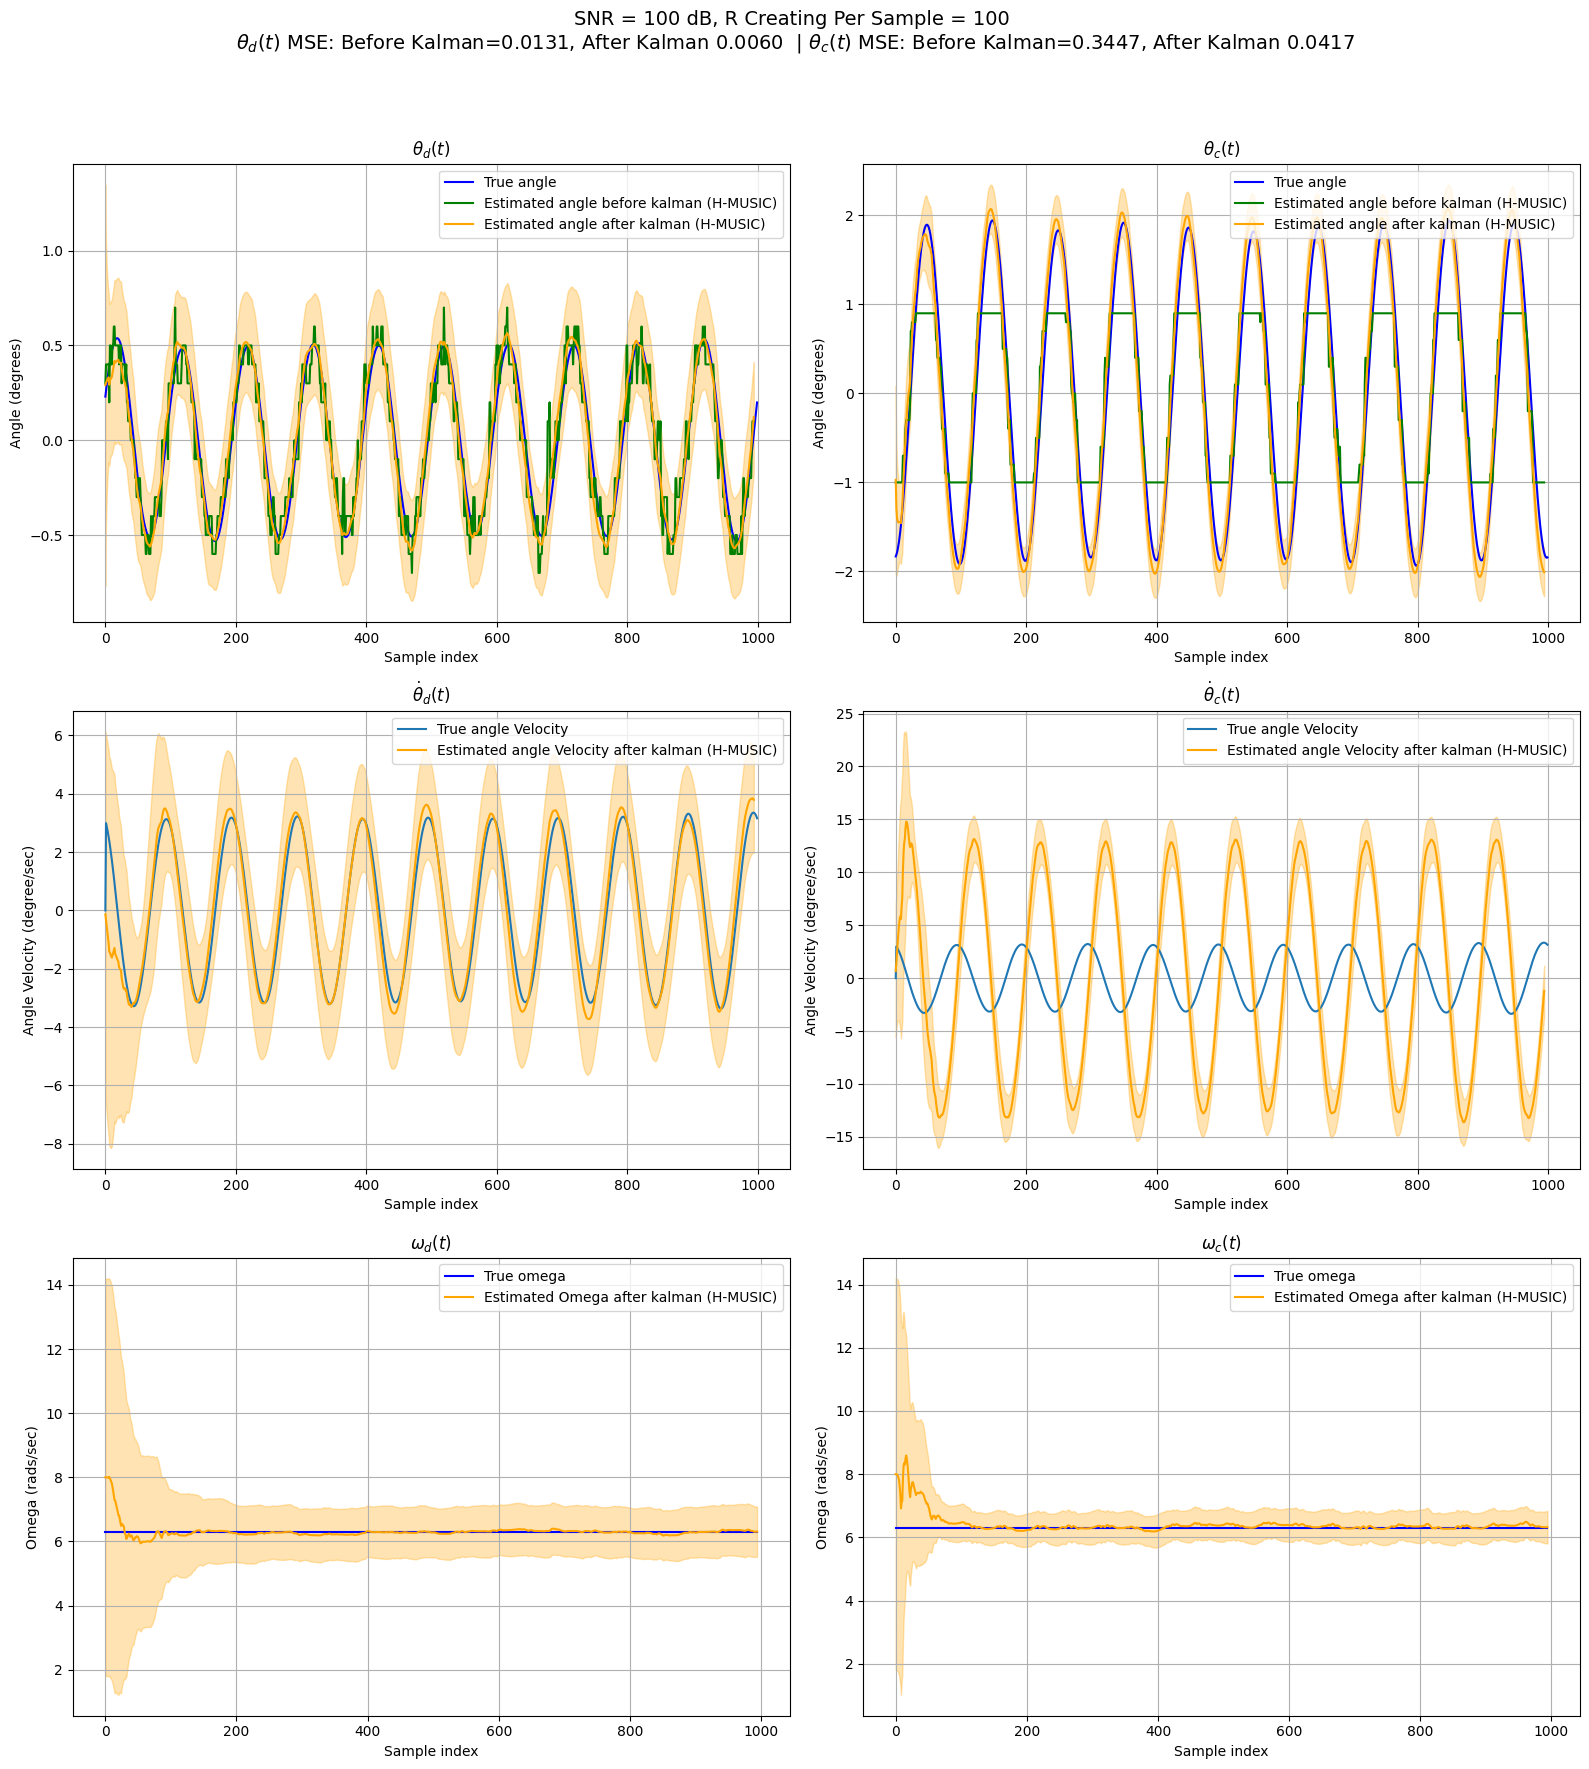

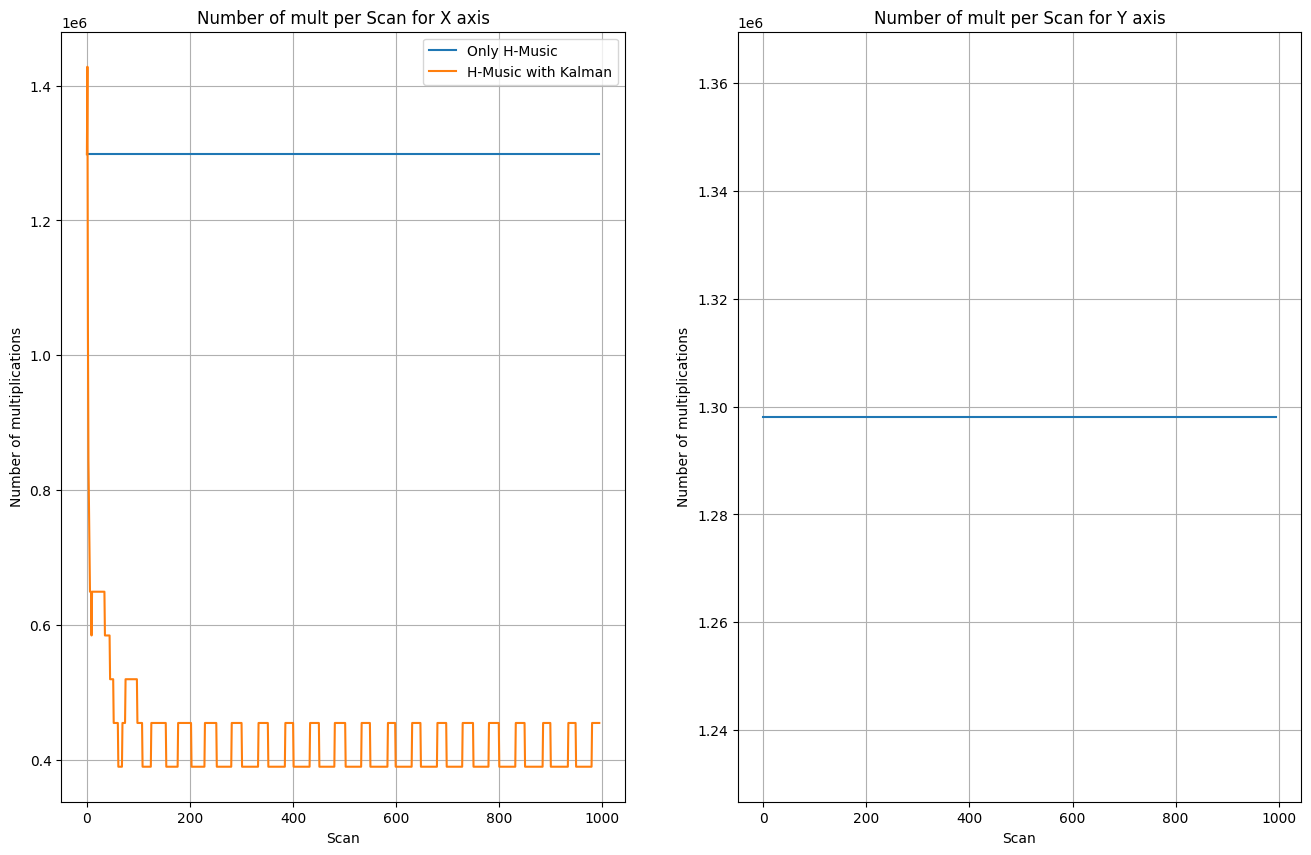

In [91]:
from scipy.linalg import dft

# ===== Simulation parameters =====
rf_freq = 28e9
sample_freq = 1e9
ant_per_sub_array = 6
num_rf = 6
bw = 200e6
samples_for_R_calc = 100
snr_vector = [100]

duration_time = 10
R_creating_freq_vector = [100]

angle_res=0.1
doa_angle_serach= np.arange(-1, 1, angle_res)
doa_angles_with_kalman_vec = [np.copy(doa_angle_serach) for _ in range(2)]
doa_angles_without_kalman_vec= np.arange(-1, 1, angle_res)
wavelength = 3e8 / rf_freq
d = wavelength / 2

swing_amplitude_factor = 1
NumberOfbitsForPhaseShifter=8

random_phase_en = True # If false, use identity matrix that is collected in steps
plot_the_Pole = False # let use plot if we want to
state_variance_plot =([True,True], #[plot position, plot position variance]
                      [True,True], #[plot angle velocity, plot angle velocity variance]
                      [True,True])  #[plot omega, plot omega variance]
number_of_dimensions= 2  #it will be or 1-D or 2-D

applyAdaptiveKalman=True

my_counter_d=0
my_counter_c=0

# ===== Simulation precess =====

TimeFramsPerAngle=ant_per_sub_array
WrfQueue = deque(maxlen=TimeFramsPerAngle)
RecievedSamplesQueue_vec = []
for i in range(number_of_dimensions):
  RecievedSamplesQueue_vec.append(deque(maxlen=TimeFramsPerAngle))

cutoff = bw / sample_freq
taps = firwin(numtaps=101, cutoff=cutoff, window="hamming")

for snr in tqdm(snr_vector, desc="SNR loop", position=0):
    for R_creating_freq in tqdm(R_creating_freq_vector,
                                desc="R_creating_freq loop",
                                position=1, leave=False):

        # ~~~~~~~~~~~~~~~~~~
        # System decleration
        # ~~~~~~~~~~~~~~~~~~

        R_Calculator = RCalculator(num_rf * ant_per_sub_array, "avarage")
        D = D_creator(num_rf * ant_per_sub_array, 90, resolution=1)
        hpa = HybridPhasedArray(ant_per_sub_array, num_rf, d, wavelength,NumberOfbitsForPhaseShifter)

        cal_angles = [-10, 0, 10]
        for ang in cal_angles:
            D.GetSample(np.identity(num_rf * ant_per_sub_array), ang)
        D.Interpulate()

        Kalman_vec = []
        for i in range(number_of_dimensions):
          Kalman_vec.append(
              EKF(init_angle=0,
              init_angularVelocity=0.05,
              init_Omega=8,
              init_var=10,
              measurments_var=0.3,
              proccess_variance=0.001,
              dt=1/R_creating_freq    )
              )
        # Adaptive_Kalman_vec = [] #FIX
        # for i in range(number_of_dimensions):
        #   Adaptive_Kalman_vec.append(
        #       EKF(init_angle=0,
        #       init_angularVelocity=0.05,
        #       init_Omega=8,
        #       init_var=10,
        #       measurments_var=0.3,
        #       proccess_variance=0.001)
        #       )
        # --- Kalman vectors ---
        est_angles_before_kalman_vec = [[], []]
          #for the state vector
        est_angles_after_kalman_vec = [[], []]
        est_angles_velocities_kalman_vec=[[], []]
        est_omega_after_kalman_vec=[[], []]
          #for the variance vector
        est_var_angles_after_kalman_vec=[[], []]
        est_var_angles_velocity_after_kalman_vec=[[], []]
        est_var_omega_after_kalman_vec=[[], []]
        #MSE
        mse_before_vec = []
        mse_after_vec = []

        cnt = 0

        hmusic = HMusicDoa(
            ant_num=ant_per_sub_array,
            rf_num=num_rf,
            dist_between_ant=d,
            wave_lambda=wavelength,
            weights_matrix=None
            )
        hmusic_for_kalman= HMusicDoa(
            ant_num=ant_per_sub_array,
            rf_num=num_rf,
            dist_between_ant=d,
            wave_lambda=wavelength,
            weights_matrix=None
            )

        # ~~~~~~~~~~~~~~~~~
        # Motion generation
        # ~~~~~~~~~~~~~~~~~

        pole = SwingingPole(T=duration_time, Fs=R_creating_freq, seed=0)
        theta_d, theta_c, Ld_freq, Lc_freq, velocity_d, velocity_c = pole.run() * swing_amplitude_factor
        pole_movement_vec = [theta_d, theta_c, Ld_freq, Lc_freq, velocity_d, velocity_c]
        if(plot_the_Pole):
          pole.plot_results()


        # ===== Main loop =====
        for theta_idx in tqdm(range(len(pole_movement_vec[0])),
                              desc="theta_idx loop",
                              position=2, leave=False):
            # --- Generate baseband signal ---
            noise = np.random.normal(0, 1, samples_for_R_calc) + \
                    1j * np.random.normal(0, 1, samples_for_R_calc)
            signal0 = lfilter(taps, 1.0, noise)

            # --- Generate Wrf and use hybrid phased rray ---
            Wrf_Frame = np.zeros((num_rf, num_rf * ant_per_sub_array), dtype=complex)
            Wrf_Frame_noisy = np.zeros((num_rf, num_rf * ant_per_sub_array), dtype=complex)
            if random_phase_en:
              for i in range(num_rf):
                  # random_noisy_phases, random_phases = GeneratePhase(NumberOfbitsForPhaseShifter,ant_per_sub_array)
                  random_noisy_phases, random_phases = hpa.GeneratePhase()
                  Wrf_Frame[i, i * ant_per_sub_array:(i + 1) * ant_per_sub_array] = random_phases
                  Wrf_Frame_noisy[i, i * ant_per_sub_array:(i + 1) * ant_per_sub_array] = random_noisy_phases
            else:
                cnt_mod = cnt % num_rf
                Wrf_Frame = dft(num_rf * ant_per_sub_array)[cnt_mod * num_rf: (cnt_mod+1) * num_rf]
                Wrf_Frame_noisy=Wrf_Frame
                cnt += 1
            WrfQueue.append(Wrf_Frame)  # Continue
            hpa.Config(Wrf_Frame_noisy)# Danel- maybe FIX

            received_matrix_vec = []
            for i in range(number_of_dimensions):
              received_matrix_vec.append(
                hpa.GetSamples(signal0, pole_movement_vec[i][theta_idx])
              )

            # --- Add uncorrelated noise and store signal---
            noise_power = np.sqrt(2) / np.sqrt(snr)
            for i in range(number_of_dimensions):
              received_matrix_vec[i] += noise_power * (
                  np.random.randn(*received_matrix_vec[0].shape) +
                  1j * np.random.randn(*received_matrix_vec[0].shape)
              )

            for i in range(number_of_dimensions):
              RecievedSamplesQueue_vec[i].append(received_matrix_vec[i])
            if(len(RecievedSamplesQueue_vec[0]) < TimeFramsPerAngle):
              continue

            # --- Covariance /Autocorrelation---
            Wrf = np.vstack(WrfQueue)
            hmusic.UpdateWRF(Wrf)
            hmusic_for_kalman.UpdateWRF(Wrf)

            received_matrix_Over_Time_vec = []
            for j in range(number_of_dimensions):
              received_matrix_Over_Time_vec.append(np.zeros((num_rf * ant_per_sub_array, ant_per_sub_array * samples_for_R_calc),dtype=complex))
              for i in range(ant_per_sub_array):
                received_matrix_Over_Time_vec[j][i*num_rf:(i+1)*num_rf, i*samples_for_R_calc:(i+1)*samples_for_R_calc] = RecievedSamplesQueue_vec[j][i]

            R_vec = []
            for i in range(2):
              R_vec.append(R_Calculator.GetSamples(received_matrix_Over_Time_vec[i]))

            # --- Run H-MUSIC ---
              #without kalman
            for i in range(number_of_dimensions):
              angles, power_db = hmusic.GetSamples(
                  R_vec[i], D,i, scanAnglesDeg=doa_angles_without_kalman_vec, signal_count=1,
              )
              est_angle = angles[np.argmax(power_db)]
              est_angles_before_kalman_vec[i].append(est_angle)
              #with kalman
            for i in range(number_of_dimensions):
              angles, power_db = hmusic_for_kalman.GetSamples(
                  R_vec[i], D,i, scanAnglesDeg=doa_angles_with_kalman_vec[i], signal_count=1,
              )
              est_angle = angles[np.argmax(power_db)]
              if(applyAdaptiveKalman==True):
                if(i==0):
                  print(f"the Xm prediction for iteration {my_counter_d +1} is{Kalman_vec[i].mX_predict[0,0]} with variance of {Kalman_vec[i].mP_predict[0,0]}")
                else:
                  print(f"the Xm prediction for iteration {my_counter_c +1} is{Kalman_vec[i].mX_predict[0,0]} with variance of {Kalman_vec[i].mP_predict[0,0]}")
                state_after_Kalman, var_after_Kalman = Kalman_vec[i].GetSampels(est_angle)
                  #the state
                est_angles_after_kalman_vec[i].append(state_after_Kalman[0])
                est_angles_velocities_kalman_vec[i].append(state_after_Kalman[1])
                est_omega_after_kalman_vec[i].append(state_after_Kalman[2])
                 #the varianc
                est_var_angles_after_kalman_vec[i].append(var_after_Kalman[0])
                est_var_angles_velocity_after_kalman_vec[i].append(var_after_Kalman[1])
                est_var_omega_after_kalman_vec[i].append(var_after_Kalman[2])
                 # update the scan
                if(i==0):
                  my_counter_d +=1
                  print(f"in iteretion {my_counter_d} the updated position is {Kalman_vec[i].mX[0,0]} while the true value is {pole_movement_vec[i][ant_per_sub_array - 1+my_counter_c-1]} ")
                else:
                  my_counter_c +=1
                  print(f"in iteretion {my_counter_c} the updated position is {Kalman_vec[i].mX[0,0]} while the true value is {pole_movement_vec[i][ant_per_sub_array - 1+my_counter_c-1]} ")

                sigma = np.sqrt(Kalman_vec[i].mP_predict[0,0])
                center = Kalman_vec[i].mX_predict[0,0]
                doa_angles_with_kalman_vec[i]= np.arange(center - 2*sigma,
                                             center+ 2*sigma,
                                             angle_res)

            # ===== End of Main loop =====

        # ===== Kalman and evaluate =====

        #insert the results for the number of dimensions
        for i in range(number_of_dimensions):
          est_angles_before_kalman_vec[i] = np.squeeze(np.array(est_angles_before_kalman_vec[i]))
          mse_before_vec.append(mean_squared_error(pole_movement_vec[i][ant_per_sub_array - 1:], est_angles_before_kalman_vec[i]))
          if(applyAdaptiveKalman==False):
            state_after_Kalman, var_after_Kalman= Kalman_vec[i].GetSampels(est_angles_before_kalman_vec[i])
            #orgenize the data

              #the state
            est_angles_after_kalman_vec[i]=(state_after_Kalman[:, 0])
            est_angles_velocities_kalman_vec[i]=(state_after_Kalman[:,1])
            est_omega_after_kalman_vec[i]=(state_after_Kalman[:,2])

              #the varianc
            est_var_angles_after_kalman_vec[i]=(var_after_Kalman[:,0])
            est_var_angles_velocity_after_kalman_vec[i]=(var_after_Kalman[:,1])
            est_var_omega_after_kalman_vec[i]=(var_after_Kalman[:,2])

            #end of IF

            #the MSE
          est_angles_after_kalman_vec[i]= np.squeeze(np.array(est_angles_after_kalman_vec[i]))
          mse_after_vec.append(mean_squared_error(pole_movement_vec[i][ant_per_sub_array - 1:], est_angles_after_kalman_vec[i]))

        # ===== Plot =====
        # --- 95% Confidence intervals (±1.96 * std) ---
        ciPosition=1.96 * np.sqrt(est_var_angles_after_kalman_vec)
        ciVelocity= 1.96 * np.sqrt(est_var_angles_velocity_after_kalman_vec)
        ciOmega= 1.96 * np.sqrt(est_var_omega_after_kalman_vec)
        # --- Titels ---
        Titel= ["$\\theta_d(t)$", "$\\theta_c(t)$",
                r"$\dot{\theta}_{d}(t)$",r"$\dot{\theta}_{c}(t)$",
                "$\\omega_d(t)$","$\\omega_c(t)$"]
        PlotSimulation(state_variance_plot,
         number_of_dimensions,
         Titel,
         pole_movement_vec,
         est_angles_before_kalman_vec,
         est_angles_after_kalman_vec,
         est_angles_velocities_kalman_vec,
         est_omega_after_kalman_vec,
         ciPosition,
         ciVelocity,
         ciOmega,
         mse_before_vec,
         mse_after_vec)

        fig, axes = plt.subplots(1, number_of_dimensions, figsize=(16, 10))
        axes = axes.flatten()

        y1=np.array(hmusic.mArrayOfMultiplicationPerScan[0])
        x1=np.arange(len(y1))
        y1_with_k= np.array(hmusic_for_kalman.mArrayOfMultiplicationPerScan[0])+ np.array(Kalman_vec[0].mArrayOfmultiplications)

        y2=hmusic.mArrayOfMultiplicationPerScan[1]
        x2=np.arange(len(y2))

        # Plot first subplot
        axes[0].plot(x1, y1, label='Only H-Music')
        axes[0].plot(x1, y1_with_k, label='H-Music with Kalman')
        axes[0].set_xlabel('Scan')
        axes[0].set_ylabel('Number of multiplications')
        axes[0].set_title('Number of mult per Scan for X axis')
        axes[0].grid(True)
        axes[0].legend()

        # Plot second subplot
        axes[1].plot(x2, y2)
        axes[1].set_xlabel('Scan')
        axes[1].set_ylabel('Number of multiplications')
        axes[1].set_title('Number of mult per Scan for Y axis')
        axes[1].grid(True)

        plt.show()




